# Single cell RNA-seq analysis

This notebooks contains the code used for the analysis and plotting of single-cell RNA-seq data from the GSE162170 dataset. It includes the instructions to generate the plots shown in the report.

## Import libraries

In [ ]:
library(magick)
library(tiff)
library(Seurat)
library(Matrix)
library(stringr)
library(readr)
library(Matrix)
library(data.table)
library(dplyr)
library(biomaRt)
library(AUCell)
library(ggplot2)
library(ropls)
library(grid)
library(tidyr)

In [ ]:
library(magick)

# Read TIFF
img <- image_read("example.tiff")

# Convert to PNG
image_write(img, path = "example.png", format = "png")

## Set working directory and load data

In [ ]:
cwd <- getwd()
data <- normalizePath(file.path(cwd, "../output_files/Single_Cell"))
figures <- normalizePath(file.path(cwd, "../figures/Single_Cell"))

metadata_file <- read.delim(file.path(data,"GSE162170_rna_cell_metadata.txt"),
  header = TRUE,
  sep = "\t",
  quote = "",
  comment.char = "",
  row.names = 1
)

counts_file <- fread(file.path(data,"counts_filtered.tsv"), data.table = FALSE)

sample_file <- read.table(file.path(data,"GSE162170_rna_sample_qc.tsv"))

auc_score <- read.csv(file.path(data,"aucell_values_chip.csv"))

## Data processing

In [ ]:
## Counts file processing
rownames(counts_file) <- counts_file[[1]]
counts_file[[1]] <- NULL
counts_file <- Matrix(as.matrix(counts_file), sparse = TRUE)
"ENSG00000171532" %in% rownames(counts_file)

## Sample file processing
colnames(sample_file) <- sample_file[1,]
sample_file <- sample_file[-1, ]


## Seurat object creation and normalization

In [ ]:
tiss <- CreateSeuratObject(counts = counts_file)
# create a filtered metadata file that contain only the cells that are present after the downsampling
metadata_file_filtered <- metadata_file[rownames(metadata_file) %in% colnames(counts_file)]
# check if the cells in both metadata and counts are the same
all(rownames(metadata_file_filtered) == colnames(counts_file))
# add the metadata to the Seurat object
tiss <- AddMetaData(object = tiss, metadata_file_filtered)
# subtract the established bashline
tiss <- AddMetaData(object = tiss, tiss$Percent.MT, col.name = "Percent.MT")
# Add the AUCell score to the Seurat object
tiss <- AddMetaData(
  object = tiss,
  metadata = auc_score)
# Normalize the data
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
ensembl <- useEnsembl("ensembl", 
                      dataset = "hsapiens_gene_ensembl", 
                      mirror = "us")  # or "asia" / "www"
# Define which are the genes of which we want to obtain the gene
genes <- rownames(counts_file)
# Apply the mapping and obtain the respective dataframe
gene_map <- getBM(
  filters = "ensembl_gene_id",
  attributes = c("ensembl_gene_id", "hgnc_symbol"),
  values = genes,
  mart = ensembl)
# Create a dictionary from the dataframe
gene_to_name_dict <- setNames(gene_map$hgnc_symbol, gene_map$ensembl_gene_id)
#Plot violin plot for nFeature_RNA and nCount_RNA
vln_plot_n_features_counts <- VlnPlot(tiss, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)
# Save the violin plot as a high-resolution TIFF file
ggsave(
  filename = file.path(figures,"quality_check_features_counts_vlnplot.tiff"),
  plot = vln_plot_n_features_counts,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

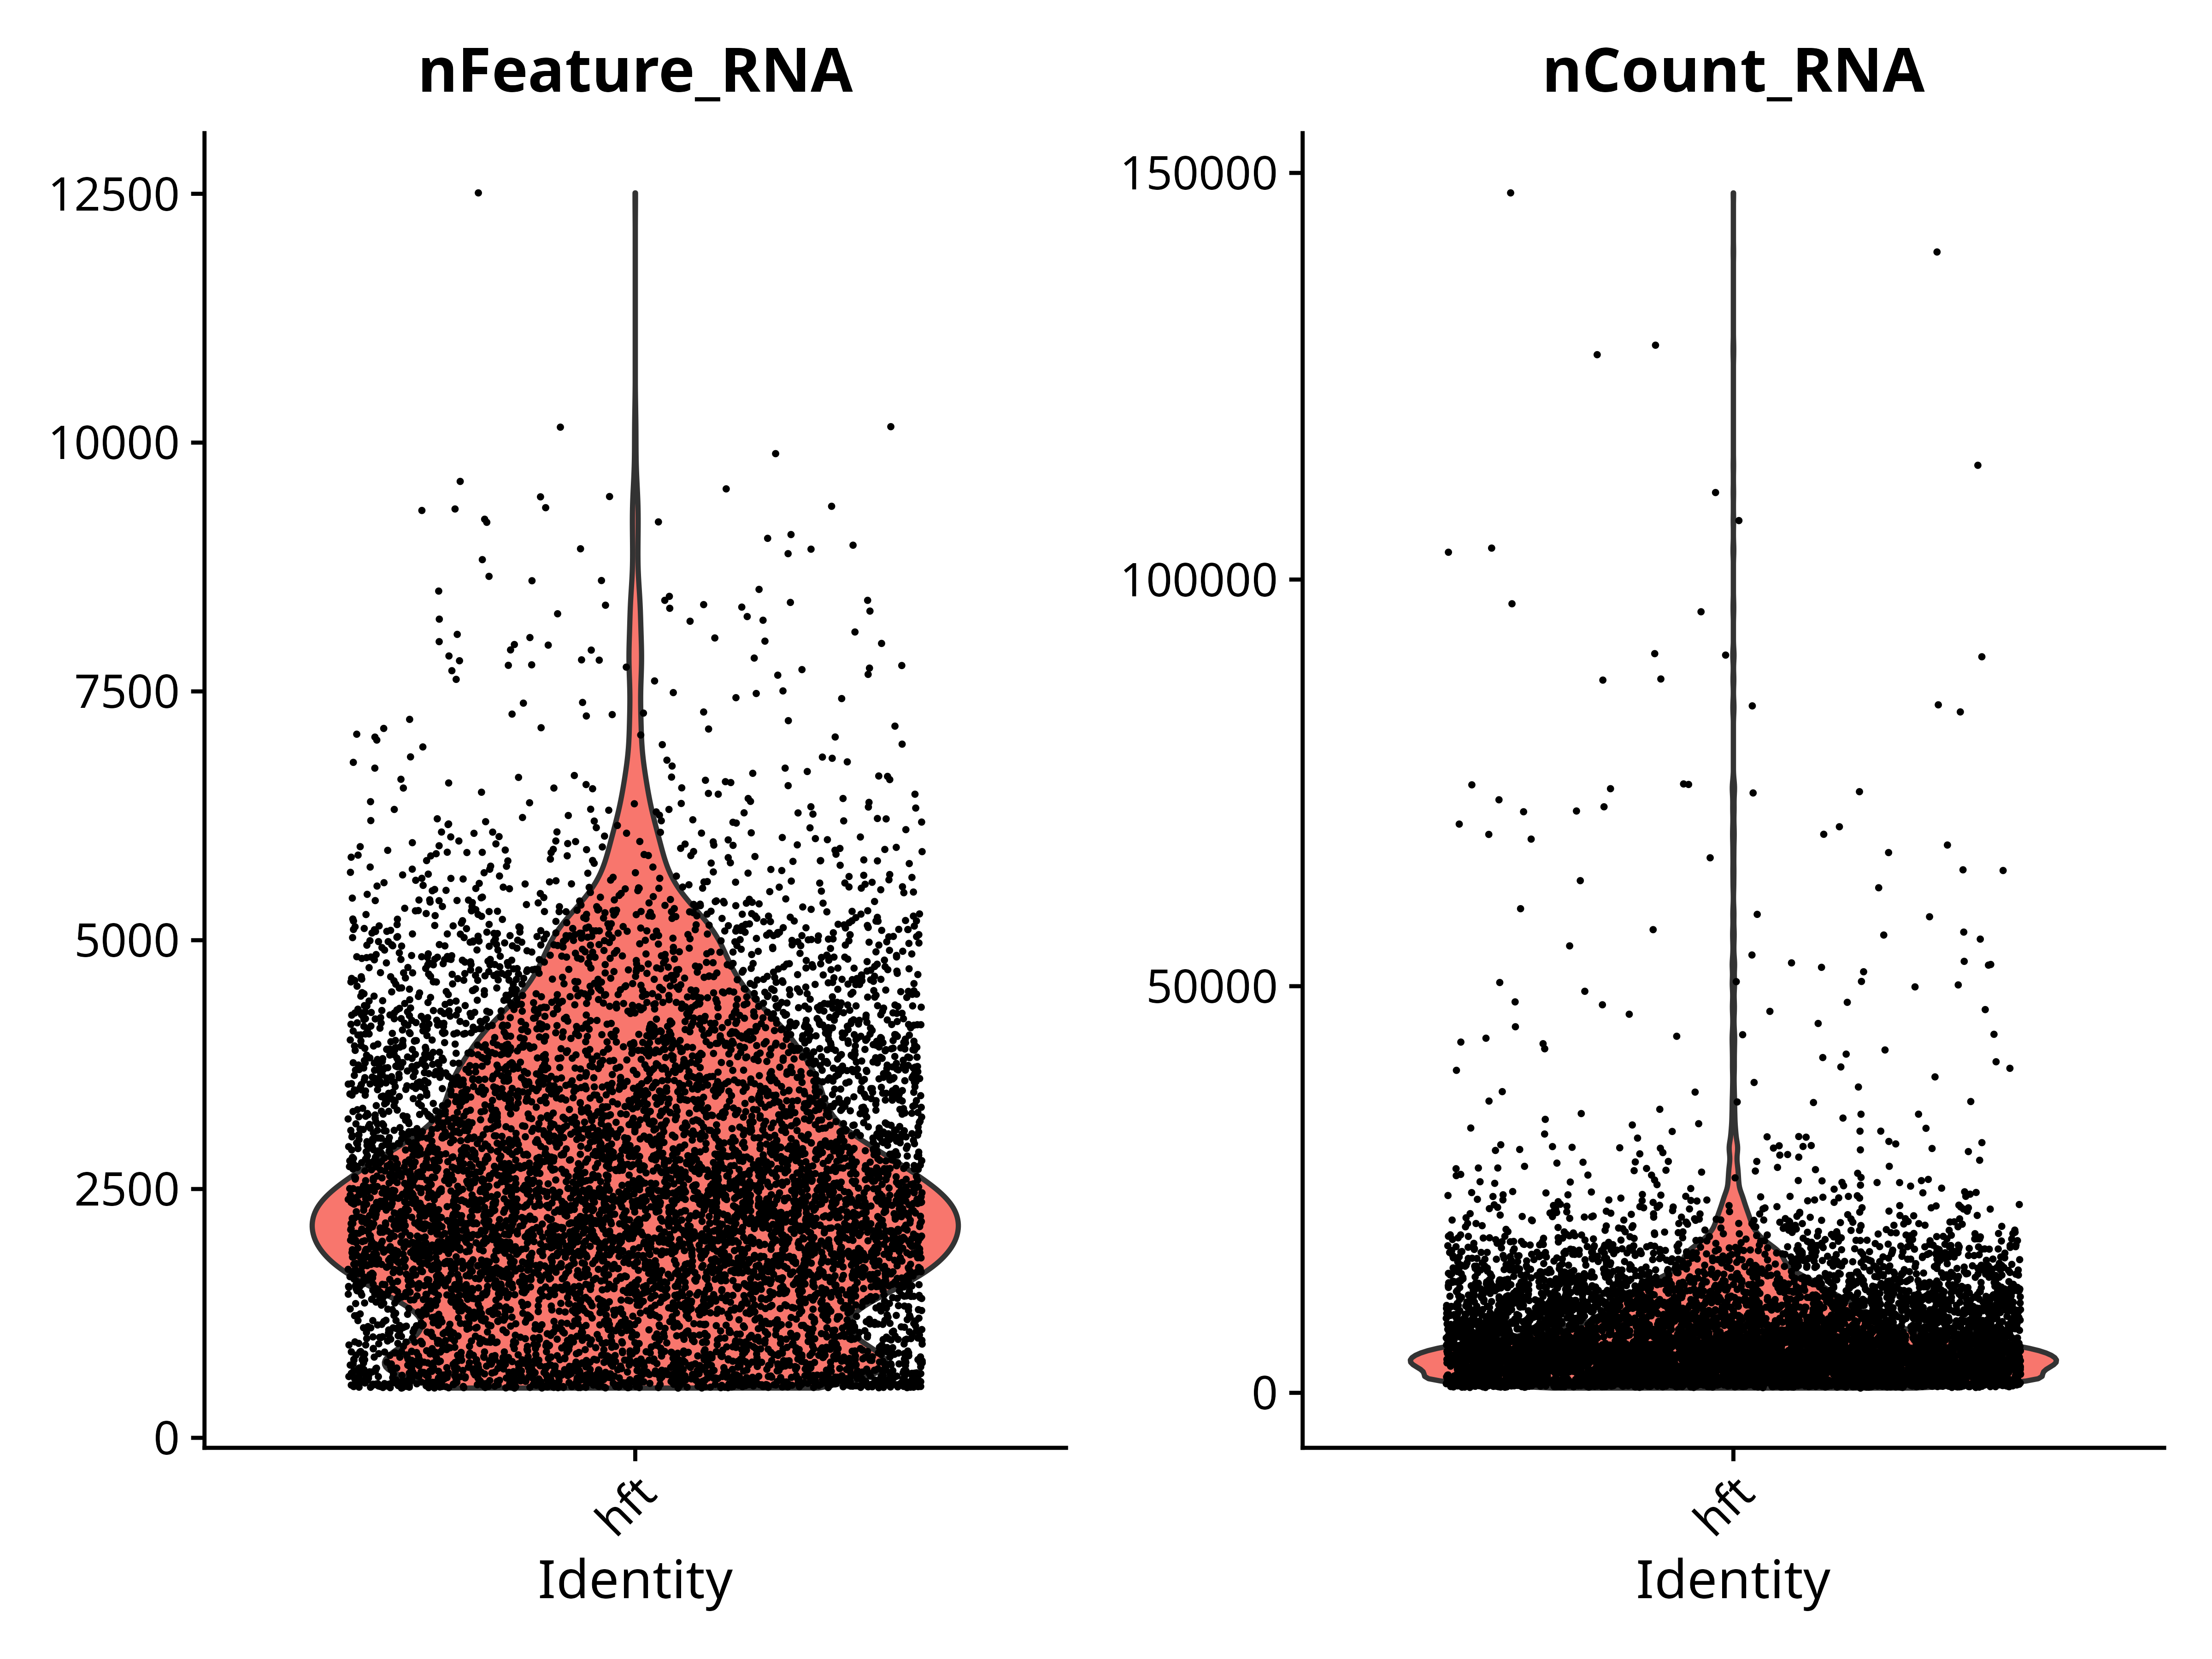

# A data frame: 1 × 7
  format width height colorspace matte filesize density  
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>    
1 TIFF    4800   3600 sRGB       TRUE   1188554 +600x+600

In [3]:
img <- image_read(file.path(figures,"quality_check_features_counts_vlnplot.tiff"))
img

In [ ]:


######################################################
# Data transformation
######################################################
# the combination of this gives scaled and centered data, 
# which improves the comparison variables with different source biological variability
tiss <- NormalizeData(object = tiss, scale.factor = 1e6)
tiss <- ScaleData(object = tiss)

######################################################
# DImensionality reduction stuff
######################################################
# Run variable feature detection
tiss <- FindVariableFeatures(tiss)

# Check top variable features
top10 <- head(VariableFeatures(tiss), 10)
print(top10)

# Plot and label
plot1 <- VariableFeaturePlot(tiss)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2
# > plot2
# Error in grid.Call(C_convert, x, as.integer(whatfrom), as.integer(whatto),  : 
#                      Viewport has zero dimension(s)
# Export to PDF
pdf("/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/variable_features_plot.pdf", width=8, height=6)
plot1
dev.off()
pdf("/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/variable_features_plot_with_labels.pdf", width=8, height=6)
plot2
dev.off()
# To know which are actually the genes
top10_symbols <- gene_to_name_dict[top10]
# For any missing mappings, keep the original Ensembl ID
top10_symbols[is.na(top10_symbols)] <- top10[is.na(top10_symbols)]
# ENSG00000078596 ENSG00000184113 ENSG00000276070 ENSG00000275302 ENSG00000276085 ENSG00000118785 ENSG00000277632 
# "ITM2A"         "CLDN5"        "CCL4L2"          "CCL4"        "CCL3L3"          "SPP1"          "CCL3" 
# ENSG00000188536 ENSG00000196565 ENSG00000244734 
# "HBA2"          "HBG2"           "HBB" 

# now let's save those genes that are most variable
# Use variable genes (found by Seurat)
variable_genes <- VariableFeatures(tiss)

tiss <- RunPCA(tiss, features = VariableFeatures(object = tiss))
ElbowPlot(tiss, ndims = 50)

pdf("/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/elbow_plot_pca.pdf", width=8, height=6)
ElbowPlot(tiss, ndims = 50)
dev.off()
# so we decided using 20 PCs based on the elbow plot results
# Let’s find clusters.
tiss <- FindNeighbors(tiss, dims = 1:20)
# with this we will use the Louvain algorithm to find clusters
tiss <- FindClusters(tiss, resolution = 0.5)
# let's group it by Age and Tissue
tiss <- RunUMAP(tiss, dims = 1:43)
# now we construct the Seurat clusters and save them
umap_plot_batch <- DimPlot(tiss, reduction = "umap", group.by = 'Batch')
umap_plot_age <- DimPlot(tiss, reduction = "umap", group.by = 'Age')
umap_plot_tissue_id <- DimPlot(tiss, reduction = "umap", group.by = 'Tissue.ID')
umap_plot_seurat_clusters <- DimPlot(tiss, reduction = "umap", group.by = 'seurat_clusters')
umap_plot_seurat_clusters_labeled <- DimPlot(tiss, reduction = "umap", group.by = 'seurat_clusters', label = TRUE)
umap_plot_cell_type <- DimPlot(tiss, reduction = "umap", group.by = 'cell_type')
umap_plot_cell_type_labeled <- DimPlot(tiss, reduction = "umap", group.by = 'cell_type', label = TRUE)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/umap_plot_batch.tiff",
  plot = umap_plot_batch,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)
ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/umap_plot_age.tiff",
  plot = umap_plot_age,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)
ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/umap_plot_tissue_id.tiff",
  plot = umap_plot_tissue_id,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)
ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/umap_plot_seurat_clusters.tiff",
  plot = umap_plot_seurat_clusters,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)
ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/umap_plot_seurat_clusters_labeled.tiff",
  plot = umap_plot_seurat_clusters_labeled,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)
ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/umap_plot_cell_type.tiff",
  plot = umap_plot_cell_type,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)
ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/umap_plot_cell_type_labeled.tiff",
  plot = umap_plot_cell_type_labeled,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

# Now we will procede with feature plots and those things
# this is for GAD1, MGP, NEUROD2, TREM2 and the AUCell score
f_plot_gad1 <- FeaturePlot(tiss, features = c("ENSG00000128683"))
f_plot_mgp <- FeaturePlot(tiss, features = c("ENSG00000111341"))
f_plot_neurod2 <- FeaturePlot(tiss, features = c("ENSG00000171532"))
f_plot_trem2 <- FeaturePlot(tiss, features = c("ENSG00000095970"))
f_plot_aucscore <- FeaturePlot(tiss, features = c("geneSet"))

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/feature_plot_gad1.tiff",
  plot = f_plot_gad1,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)
ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/feature_plot_mgp.tiff",
  plot = f_plot_mgp,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)
ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/feature_plot_neurod2.tiff",
  plot = f_plot_neurod2,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)
ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/feature_plot_trem2.tiff",
  plot = f_plot_trem2,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)
ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/feature_plot_aucscore.tiff",
  plot = f_plot_aucscore,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

######################################################
# Find markers genes
######################################################

Idents(tiss) <- tiss$cell_type
celltypes <- unique(Idents(tiss))
comparisons <- combn(celltypes, 2, simplify = FALSE)

outdir <- "/home/alberto/Desktop/pairwise_markers"
pairwise_markers <- list()
for (pair in comparisons) {
  cellA <- pair[1]
  cellB <- pair[2]
  
  message("Comparing ", cellA, " vs ", cellB)
  
  # sanitize names for filenames
  safeA <- str_replace_all(cellA, "[^A-Za-z0-9_-]", "_")
  safeB <- str_replace_all(cellB, "[^A-Za-z0-9_-]", "_")
  
  markers <- FindMarkers(
    tiss,
    ident.1 = cellA,
    ident.2 = cellB,
    only.pos = FALSE,
    min.pct = 0.25,
    logfc.threshold = 0.25
  )
  
  # store in memory
  pair_name <- paste(cellA, "_vs_", cellB, sep = "")
  pairwise_markers[[pair_name]] <- markers
  
  # safe output file path
  out_path <- file.path(outdir, paste0(safeA, "_vs_", safeB, "_markers.tsv"))
  
  write.table(markers, file = out_path, sep = "\t", quote = FALSE, col.names = NA)
}

################# put together all tables
all_markers_df <- bind_rows(
  lapply(names(pairwise_markers), function(x) {
    df <- pairwise_markers[[x]]
    df$comparison <- x
    df
  })
)

write.table(all_markers_df, "/home/alberto/Desktop/pairwise_markers/all_pairwise_markers_cell_type.tsv", sep="\t", quote=FALSE, col.names=NA)

# now for the age agrupation
Idents(tiss) <- tiss$Age   # or use tiss$seurat_clusters
celltypes <- unique(Idents(tiss))
comparisons <- combn(celltypes, 2, simplify = FALSE)

outdir <- "/home/alberto/Desktop/pairwise_markers"
pairwise_markers <- list()
for (pair in comparisons) {
  cellA <- pair[1]
  cellB <- pair[2]
  
  message("Comparing ", cellA, " vs ", cellB)
  
  # sanitize names for filenames
  safeA <- str_replace_all(cellA, "[^A-Za-z0-9_-]", "_")
  safeB <- str_replace_all(cellB, "[^A-Za-z0-9_-]", "_")
  
  markers <- FindMarkers(
    tiss,
    ident.1 = cellA,
    ident.2 = cellB,
    only.pos = FALSE,
    min.pct = 0.25,
    logfc.threshold = 0.25
  )
  
  # store in memory
  pair_name <- paste(cellA, "_vs_", cellB, sep = "")
  pairwise_markers[[pair_name]] <- markers
  
  # safe output file path
  out_path <- file.path(outdir, paste0(safeA, "_vs_", safeB, "_markers.tsv"))
  
  write.table(markers, file = out_path, sep = "\t", quote = FALSE, col.names = NA)
}

################# put together all tables
all_markers_df <- bind_rows(
  lapply(names(pairwise_markers), function(x) {
    df <- pairwise_markers[[x]]
    df$comparison <- x
    df
  })
)

write.table(all_markers_df, "/home/alberto/Desktop/pairwise_markers/all_pairwise_markers_age.tsv", sep="\t", quote=FALSE, col.names=NA)

###################### find unique markers per cell type
unique_markers <- list()

for (ct in celltypes) {
  others <- setdiff(celltypes, ct)
  tmp <- list()
  
  for (other in others) {
    res <- FindMarkers(tiss, ident.1 = ct, ident.2 = other, only.pos = TRUE)
    tmp[[other]] <- res
  }
  
  # Intersect top markers across all comparisons
  shared_genes <- Reduce(intersect, lapply(tmp, rownames))
  unique_markers[[ct]] <- shared_genes
}

unique_markers

######################################################
# Ridge plots and Violin plots, for enurod2
######################################################

sc_rdg <- RidgePlot(tiss, features = 'ENSG00000171532', group.by = 'seurat_clusters')
ct_rdg <- RidgePlot(tiss, features = 'ENSG00000171532', group.by = 'cell_type')
ag_rdg <- RidgePlot(tiss, features = 'ENSG00000171532', group.by = 'Age')
tsid_rdg <- RidgePlot(tiss, features = 'ENSG00000171532', group.by = 'Tissue.ID')
ba_rdg <- RidgePlot(tiss, features = 'ENSG00000171532', group.by = 'Batch')
smid_rdg <- RidgePlot(tiss, features = 'ENSG00000171532', group.by = 'Sample.ID')

sc_vln <- VlnPlot(tiss, features = 'ENSG00000171532', group.by = 'seurat_clusters')
ct_vln <- VlnPlot(tiss, features = 'ENSG00000171532', group.by = 'cell_type')
ag_vln <- VlnPlot(tiss, features = 'ENSG00000171532', group.by = 'Age')
tsid_vln <- VlnPlot(tiss, features = 'ENSG00000171532', group.by = 'Tissue.ID')
ba_vln <- VlnPlot(tiss, features = 'ENSG00000171532', group.by = 'Batch')
smid_vln <- VlnPlot(tiss, features = 'ENSG00000171532', group.by = 'Sample.ID')

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/ridge_neurod2_seuract_clusters.tiff",
  plot = sc_rdg,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/ridge_neurod2_cell_type.tiff",
  plot = ct_rdg,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/ridge_neurod2_age.tiff",
  plot = ag_rdg,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/ridge_neurod2_tissue_id.tiff",
  plot = tsid_rdg,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/ridge_neurod2_batch.tiff",
  plot = ba_rdg,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/ridge_neurod2_sample_id.tiff",
  plot = smid_rdg,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

# ###############################################
ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/vln_neurod2_seuract_clusters.tiff",
  plot = sc_vln,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/vln_neurod2_cell_type.tiff",
  plot = ct_vln,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/vln_neurod2_age.tiff",
  plot = ag_vln,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/vln_neurod2_tissue_id.tiff",
  plot = tsid_vln,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/vln_neurod2_batch.tiff",
  plot = ba_vln,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/vln_neurod2_sample_id.tiff",
  plot = smid_vln,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

######################################################
# Percentage of cells expressing an specific gene
######################################################

# gene of interest (NEUROD2)
gene <- "ENSG00000171532"

# make sure metadata has Sample.ID and Tissue.ID
meta <- tiss@meta.data

# 1) percent expressing, mean, median per tissue
expr_mat <- as.matrix(GetAssayData(tiss, assay = "RNA", slot = "counts")) # raw counts
if(!gene %in% rownames(expr_mat)) stop("Gene not found in counts matrix")

df_summary_cell_type <- meta %>%
  mutate(cell = rownames(meta),
         expr = as.numeric(expr_mat[gene, cell])) %>%
  # group_by(cell_type) %>%
  group_by(cell_type) %>%
  # group_by(CTxA) %>%
  summarize(
    n_cells = n(),
    n_samples = n_distinct(Sample.ID),
    pct_expr = 100 * mean(expr > 0),
    mean_expr = mean(expr),
    mean_expr_in_expr_cells = ifelse(sum(expr>0)>0, mean(expr[expr>0]), NA),
    median_expr = median(expr)
  ) %>%
  arrange(desc(mean_expr))

df_summary_age <- meta %>%
  mutate(cell = rownames(meta),
         expr = as.numeric(expr_mat[gene, cell])) %>%
  # group_by(cell_type) %>%
  group_by(Age) %>%
  # group_by(CTxA) %>%
  summarize(
    n_cells = n(),
    n_samples = n_distinct(Sample.ID),
    pct_expr = 100 * mean(expr > 0),
    mean_expr = mean(expr),
    mean_expr_in_expr_cells = ifelse(sum(expr>0)>0, mean(expr[expr>0]), NA),
    median_expr = median(expr)
  ) %>%
  arrange(desc(mean_expr))

# optional pretty table
write.table(df_summary_cell_type, "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/neurod2_cell_type_summary.tsv", sep="\t", row.names=FALSE, quote=FALSE)

write.table(df_summary_age, "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/neurod2_age_summary.tsv", sep="\t", row.names=FALSE, quote=FALSE)

vln_cell_type_neurod2 <- VlnPlot(tiss, features = gene, group.by = "cell_type", pt.size = 0.5) + NoLegend()
vln_age_neurod2 <- VlnPlot(tiss, features = gene, group.by = "Age", pt.size = 0.5) + NoLegend()

cell_type_percentage_expressing_neurod2 <- ggplot(df_summary_cell_type, aes(x = reorder(cell_type, -pct_expr), y = pct_expr)) +
  geom_col() + coord_flip() + ylab("% cells expressing") + xlab("Tissue") +
  theme_minimal()
age_percentage_expressing_neurod2 <- ggplot(df_summary_age, aes(x = reorder(Age, -pct_expr), y = pct_expr)) +
  geom_col() + coord_flip() + ylab("% cells expressing") + xlab("Tissue") +
  theme_minimal()

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/vln_neurod2_per_cell_type.tiff",
  plot = vln_cell_type_neurod2,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/ratio_neurod2_per_cell_type.tiff",
  plot = cell_type_percentage_expressing_neurod2,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/vln_neurod2_per_age.tiff",
  plot = vln_age_neurod2,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/ratio_neurod2_per_age.tiff",
  plot = age_percentage_expressing_neurod2,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

######################################################
# Sassy plots for NEUROD2 relative expression in each cell and each cell type
######################################################

# Extrae las coordenadas UMAP + metadatos + expresión de NeuroD2
gene <- "ENSG00000171532"
umap_df <- as.data.frame(Embeddings(tiss, "umap")) %>%
  mutate(
    cell = rownames(.),
    cell_type = tiss$cell_type,
    neurod2 = FetchData(tiss, vars = gene)[,1]
  )

# UMAP coloreado por expresión, con elipses de cell_type
plot_umap_neurod2_cooler <- ggplot(umap_df, aes(umap_1, umap_2)) +
  geom_point(aes(color = neurod2), size = 0.4, alpha = 0.8) +
  # stat_ellipse(aes(group = cell_type), color = "black", lwd = 0.4, linetype = "dashed") +
  scale_color_gradientn(colors = c("grey90", "royalblue", "darkred")) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "right",
    panel.grid = element_blank()
  ) +
  labs(
    color = "NEUROD2\nexpression",
    title = "UMAP colored by NEUROD2 expression\nEllipses show cell-type clusters"
  )

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/umap_neurod2_cooler.tiff",
  plot = plot_umap_neurod2_cooler,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

centroids <- umap_df %>%
  group_by(cell_type) %>%
  summarise(
    umap_1 = mean(umap_1),
    umap_2 = mean(umap_2)
  )

# Crear el plot
plot_umap_neurod2_cooler_cell_type_labeled <- ggplot(umap_df, aes(umap_1, umap_2)) +
  geom_point(aes(color = neurod2), size = 0.4, alpha = 0.8) +
  stat_ellipse(aes(group = cell_type), color = "black", lwd = 0.4, linetype = "dashed") +
  geom_text(
    data = centroids,
    aes(label = cell_type),
    color = "black",
    size = 3,
    fontface = "bold"
  ) +
  scale_color_gradientn(colors = c("grey90", "royalblue", "darkred")) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "right",
    panel.grid = element_blank()
  ) +
  labs(
    color = "NEUROD2\nexpression",
    title = "UMAP colored by NEUROD2 expression\nEllipses show cell-type clusters"
  )

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/umap_neurod2_cooler_cell_type_labeled.tiff",
  plot = plot_umap_neurod2_cooler_cell_type_labeled,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

######################################################
# OPLS pipeline
######################################################

counts_file <- fread("/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/data/single_cell_rna_seq/counts_filtered.tsv", data.table = FALSE)
#  Then we set the first column as the row names and delete the first column
rownames(counts_file) <- counts_file[[1]]
counts_file[[1]] <- NULL

# Normalized data
gene <- "ENSG00000171532"

if (!gene %in% rownames(counts_file)) {
  stop("❌ NEUROD2 (ENSG00000171532) not found in the data file!")
}

# define the variable that we want to predict (in this case, NEUROD2 expression)
y_cont <- as.numeric(counts_file[gene, ])

# Define X = all other genes (cells × genes)
X <- t(counts_file[setdiff(rownames(counts_file), gene), ])  # transpose to cells × genes

# Run OPLS
# define the agrupations we want to apply in the permutation
cv_segments <- min(5, nrow(X) - 1)

opls_res <- opls(
  X,
  y_cont,
  predI = 1,
  orthoI = 10,
  crossvalI = cv_segments,
  scaleC = c("none", "center", "pareto", "standard")[4],
  permI = 0
)

# OPLS
# 7918 samples x 2000 variables and 1 response
# standard scaling of predictors and response(s)
# R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort
# Total    0.539    0.624    0.56  1.84   1  10

# # Get variable importance scores
# vip_scores <- getVipVn(opls_res)
# vip_df <- data.frame(
#   gene = names(vip_scores),
#   VIP = vip_scores
# )
# vip_df <- vip_df[order(vip_df$VIP, decreasing = TRUE), ]
# 
# head(vip_df, 20)

pred_VIP <- opls_res@vipVn
ortho_VIP <- opls_res@orthoVipVn

keys <- names(pred_VIP)
pred_values <- as.numeric(pred_VIP)
ortho_values <- as.numeric(ortho_VIP)


vip_opls_df <- data.frame(
  variable = keys,
  pred = pred_values, 
  ortho = ortho_values
)

vip_filtered_df <- vip_opls_df[vip_opls_df$pred > 2,]

# pred_VIP[pred_VIP > 1]
# cat(names(pred_VIP[pred_VIP > 1]), sep = ", ")
# 
# ortho_VIP[ortho_VIP > 1]
# cat(names(ortho_VIP[ortho_VIP > 1]), sep = ", ")
# 
# opls_res@coefficientMN
# opls_res@loadingMN

p1 <- opls_res@loadingMN[, 1]       # p[1] loading (covariance)
pcorr <- opls_res@coefficientMN[, 1]        # p(corr)[1] (correlation)
names <- rownames(opls_res@loadingMN)  # variable names

# Build the dataframe
s_data <- data.frame(
  Variable = names,
  pcorr = pcorr
)

s_data_filtered <- s_data[s_data$Variable %in% vip_filtered_df$variable, ]

p1 <- opls_res@scoreMN[, 1]    
o1 <- opls_res@orthoScoreMN[, 1]

pred_ortho_df <- data.frame(
  variable = y_cont,
  p1 = p1,
  o1 = o1
)

write.csv(pred_ortho_df, paste0("/home/alberto/Desktop/pred_ortho.csv"), row.names = FALSE)

write.csv(vip_filtered_df, paste0("/home/alberto/Desktop/variates_pred_ortho_sc.csv"), row.names = FALSE)

write.csv(s_data_filtered, paste0("/home/alberto/Desktop/corr_to_splot_sc.csv"), row.names = FALSE)
#################################
pred_ortho_df <- read.csv(paste0("/home/alberto/Desktop/pred_ortho.csv"))

vip_filtered_df <- read.csv(paste0("/home/alberto/Desktop/variates_pred_ortho_sc.csv"))

s_data_filtered <- read.csv(paste0("/home/alberto/Desktop/corr_to_splot_sc.csv"))

# ---------------------------

scores_plot_opls <- ggplot(pred_ortho_df, aes(x = p1, y = o1, color = variable)) +
  geom_point(size = 3) +
  # geom_text(vjust = -0.5, size = 3) +
  stat_ellipse(
    type = "norm", 
    level = 0.95,
    color = "#262626",       # Border color
    fill = "#EBEBEB",         # Interior fill color
    alpha = 0.1,             # Transparency of fill
    linewidth = 1,
    geom = "polygon"         # Important: needed for filled ellipses
  )+
  scale_color_gradient(  low = "#1C9C89",     # azul verdoso
                         # mid = "#D3D3D3",     # gris claro (puedes ajustar)
                         high = "#643173",    # morado
                         # name = "IL-10 (pg/mL)"
                         # name = "CRP (ng/mL)"
  ) +  # Puedes personalizar los colores
  theme_minimal() +
  labs(title = "", x = "p1", y = "o1") +
  coord_cartesian(xlim = c(-7.5, 7.5), ylim = c(-10, 10))+
  theme(
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    axis.title = element_text(size = 12),
    panel.grid.major = element_line(color = "grey80")
  )+
  # geom_hline(yintercept = 0, color = "#999999", linewidth = 0.6, linetype = "dashed") +
  # geom_vline(xintercept = 0, color = "#999999", linewidth = 0.6, linetype = "dashed")
  theme(
    axis.line.x = element_line(color = "#7A7A7A", linewidth = 0.75),
    axis.line.y = element_line(color = "#7A7A7A", linewidth = 0.75),
    axis.title.x = element_text(face = "bold.italic", size = 20, hjust = 0.5,color='#262626'),  # Bold X-axis title
    axis.text.x = element_text(size = 20, hjust = 0.5,color='#262626'),  # Bold X-axis title
    axis.text.y = element_text(size = 20, hjust = 0.5,color='#262626'),  # Bold X-axis title
    axis.title.y = element_text(face = "bold.italic", size = 20, hjust = 0.5,color='#262626'),  # Bold Y-axis title
    plot.title = element_text(face = "bold", size = 20, hjust = 0.5, color = '#262626'),
    panel.grid.major = element_line(color = "grey80"),
    legend.title = element_text(size = 16, face = "bold", color = "#262626"),
    legend.text  = element_text(size = 14, face = "bold", color = "#262626"),
    legend.key.size = unit(1.2, "cm")
    
  ) +
  annotation_custom(
    grob = textGrob(
      # IL-10
      label = paste("R2 = 0.624\nQ2 = 0.560"),
      # CRP
      # label = paste("R2 = 0.635\nQ2 = 0.575"),
      # this line of beneath allows to control de position of this label with the p-value and the rho value
      x = 0.981, y = 0.90, hjust = 1,
      gp = gpar(col = "#262626", fontsize = 13, fontface = "bold", fill = 'white')
    )
  )

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/scores_plot_opls.tiff",
  plot = scores_plot_opls,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)



#########################

# Transformar a formato largo
vip_long <- vip_filtered_df %>%
  pivot_longer(cols = c(pred, ortho),
               names_to = "Component",
               values_to = "VIP")

# Add a new column with gene symbols
vip_long$gene_symbol <- gene_to_name_dict[vip_long$variable]
# Remove names from the vector
vip_long$gene_symbol <- unname(vip_long$gene_symbol)

# Replace missing gene symbols with original Ensembl ID
vip_long$gene_symbol[is.na(vip_long$gene_symbol)] <- vip_long$variable

pred_order <- vip_long %>%
  filter(Component == "pred") %>%
  arrange(desc(VIP)) %>%
  pull(gene_symbol)

vip_long$gene_symbol <- factor(vip_long$gene_symbol, levels = pred_order)
# Replace missing ones with the original ID
# vip_long$gene_symbol[is.na(vip_long$gene_symbol)] <- vip_long$variable

# Hacer el gráfico de barras
ggplot(vip_long, aes(x = VIP, y = gene_symbol, fill = Component)) +
  geom_col(position = "dodge") +
  labs(x = "VIP score", y = "Gene", fill = "Component") +
  theme_minimal(base_size = 12) +
  theme(axis.text.y = element_text(size = 6))

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/scores_plot_opls.tiff",
  plot = scores_plot_opls,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 8,       # width in inches
  height = 6,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

###########################################################
###########################################################
###########################################################

# Add a color column based on correlation sign
s_data_filtered <- s_data_filtered %>%
  mutate(Color = ifelse(pcorr < 0, "Negative", "Positive"))

s_data_filtered$gene_symbol <- gene_to_name_dict[s_data_filtered$Variable]
# Remove names from the vector
s_data_filtered$gene_symbol <- unname(s_data_filtered$gene_symbol)

group_colors <- c("Negative" = "#5AA9E6", "Positive" = "orange")

# Plot: Lollipop-style VIP plot
vip_scores_sorted_colored <- ggplot(s_data_filtered, aes(x = VIP, y = reorder(gene_symbol, VIP), color = Color)) +
  geom_segment(aes(x = 0.95, xend = VIP, y = gene_symbol, yend = gene_symbol), size = 1) +
  geom_point(size = 4) +
  
  scale_color_manual(values = group_colors, name = "Correlation") +
  
  scale_x_continuous(expand = expansion(mult = c(0, 0.02)), limits = c(0.95, NA)) +
  
  labs(
    title = "VIP Scores by Gene",
    x = "VIP Score",
    y = ""
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = c(0.85, 0.1),
    legend.title = element_text(size = 12, face = "bold", color = "#262626"), 
    legend.text  = element_text(size = 12, face = "bold", color = "#262626"),
    legend.key = element_blank(),  
    legend.key.height = unit(0.3, "cm"),
    legend.key.width  = unit(0.8, "cm"),
    
    axis.title.x = element_text(face = "bold", size = 16, color = '#262626', margin = margin(t=15)),
    axis.text.y  = element_text(size = 12, color = '#262626', margin = margin(r=5)),
    axis.text.x  = element_text(size = 14, color = '#262626', margin = margin(t=7)),
    
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.line.x = element_line(color = "#262626", size = 1),
    axis.line.y = element_line(color = "#262626", size = 1)
  ) +
  guides(
    color = guide_legend(override.aes = list(shape = 16, size = 5))
  )

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/vip_scores_sorted_colored_opls.tiff",
  plot = vip_scores_sorted_colored,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 13,       # width in inches
  height = 13,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

######################################################
# enrichment and pathway analysis
######################################################

# Install and load gprofiler2 if needed
# install.packages("gprofiler2")
library(gprofiler2)

# Suppose your filtered gene list is in s_data_filtered
gene_list <- s_data_filtered$Variable

# Perform enrichment analysis
gost_res <- gost(
  query = gene_list,
  organism = "hsapiens",   # use appropriate organism code, e.g., "mmusculus" for mouse
  source = c("GO")  # you can include other sources if you want
)

# View results
head(gost_res$result)

# Optional: visualize top enriched GO terms
gostplot(gost_res, capped = TRUE, interactive = TRUE)

# # Extract the results table
# res <- gost_res$result

write.csv(as.matrix(gost_res$result), paste0("/home/alberto/Desktop/enrichment_sc_rna.csv"), row.names = FALSE)

res_sc_enrichment <- read.csv("/home/alberto/Desktop/enrichment_sc_rna.csv")

############################

df <- res_sc_enrichment

# Filter to keep only significant terms (optional) and p_value
df_plot <- df %>% 
  filter(significant == TRUE) %>%
  mutate(log_p = -log10(p_value))

# df_plot <- df_plot[df_plot$log_p > 16,]

# df_neuro <- df_plot %>%
#   filter(
#     grepl("neuro|nervous|differentiation", term_name, ignore.case = TRUE)
#   )

# Plot
# Define color palette for GO sources (you can tweak as you wish)
source_colors <- c(
  "GO:BP" = "#5EB1BF",  # teal
  "GO:MF" = "#F7CE3B",  # warm yellow
  "GO:CC" = "#643173"   # violet
)

# Plot with enhanced visual style

enrichment_go_processes <- ggplot(df_plot, aes(
  x = log_p,
  y = reorder(term_name, log_p),
  color = source
)) +
  # ---- thin lines like lollipops ----
geom_segment(aes(x = 0, xend = log_p, y = term_name, yend = term_name),
             linewidth = 1.2, color = "grey50") +
  
  # ---- dot at the end (optional for clarity) ----
geom_point(size = 3, stroke = 0.8) +
  
  scale_color_manual(values = source_colors) +
  
  scale_x_continuous(
    expand = expansion(mult = c(0, 0.02))  # make sure lines touch y-axis
  ) +
  
  labs(
    x = expression(-log[10]("p-value")),
    y = "",
    color = "GO Source"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.line.x = element_line(color = "#262626", linewidth = 1),
    axis.line.y = element_line(color = "#262626", linewidth = 1),
    
    axis.title.x = element_text(color = "#645D5E", face = "bold", size = 20, margin = margin(t=15)),
    axis.text.x  = element_text(size = 16, color = "#262626", margin = margin(t=7)),
    axis.text.y  = element_markdown(size = 12, color = "#262626", lineheight = 1.4, face = 'bold'),
    
    panel.grid.major   = element_blank(),
    panel.grid.minor   = element_blank(),
    panel.border       = element_blank(),
    legend.position    = "right",
    legend.title       = element_text(face = "bold", color = "#262626", size = 16),
    legend.text        = element_text(size = 14, color = "#262626"),
    plot.margin        = margin(10, 20, 10, 5),
    plot.background    = element_rect(fill = "white", color = NA),
    panel.background   = element_rect(fill = "white", color = NA)
  ) +
  guides(
    color = guide_legend(
      override.aes = list(size = 5)
    )
  )

ggsave(
  filename = "/media/alberto/External HD1/UPF/master_academic_years/first_master_academic_year/f_m_a_y_first_term/f_m_a_y_f_t_subjects/PGB_principles_of_genomes_bioinformatics/PGB_project/figures/enrichment_go_bubble_plot.tiff",
  plot = enrichment_go_processes,
  device = "tiff",
  dpi = 600,       # publication-quality resolution
  width = 13,       # width in inches
  height = 13,      # height in inches
  units = "in",
  compression = "lzw"  # lossless compression
)

#########################################################################

# This is fro the biochemical pathway data, with KEGG as target database
s_data_filtered <- read.csv("/home/alberto/Desktop/corr_to_splot_sc.csv")

# Suppose your filtered gene list is in s_data_filtered
gene_list <- s_data_filtered$Variable

# Perform enrichment analysis
kegg_res <- gost(
  query = gene_list,
  organism = "hsapiens",   # use appropriate organism code, e.g., "mmusculus" for mouse
  source = c("KEGG")  # you can include other sources if you want
)

write.csv(as.matrix(kegg_res$result), paste0("/home/alberto/Desktop/kegg_sc_rna.csv"), row.names = FALSE)